# Solar Orbiter
This example demonstrates a ballistic model inspired by the solar orbiter mission.

In [1]:
# Pykep imports
from pykep.trajopt import mga_1dsm, launchers
from pykep.planet import jpl_lp
from pykep import epoch
from pykep.core import lambert_problem, propagate_lagrangian, fb_prop
from pykep import DAY2SEC, DAY2YEAR, AU, RAD2DEG, ic2par
from pykep.trajopt.gym import solar_orbiter_resdsm, solar_orbiter_1dsm
from pykep.trajopt.gym._solar_orbiter import _solar_orbiter_udp

# Other imports
import numpy as np
from numpy.linalg import norm
from numpy import sign
from math import acos, asin, cos, exp, log, pi, sin
import matplotlib.pyplot as plt
from copy import deepcopy
import pygmo
import time

In [2]:
%matplotlib notebook

# Solar Orbiter, modelles with DSMs only on resonant arcs

In [3]:
# Solution found by Dietmar Wolz
x = [7454.239968096991, 404.2427682075494, 224.7007818627643, 166.76492404089777, 332.1943747024565, 224.70067465717648, 224.70064854708585, 674.102011793403, 449.4013940418292, 0.46175426496713623, 0.15595624336471145, 1.057897958249542, 0.5111221499713654, -0.23551244689346862, 1.0578678140141846, 0.6126539084565384, 0.0363223837410434, 1.0578389473452743, 0.15966690593566818, 0.9904935428678754, 1.05789170937413, 0.1958888817342986, 0.4998253324280215, 1.0580079586797548, 0.676246650510244, 1.0581815819568168]
earth = jpl_lp("earth")
venus = jpl_lp("venus")
seq = [earth, venus, venus, earth, venus, venus, venus, venus, venus]
solar_orbiter = _solar_orbiter_udp([7000, 8000], seq=seq, max_revs=3, dummy_DSMs=True)

# Show angle, delta v, mass and sun distance constraints
print (str(solar_orbiter.fitness(x))) 

[1.2591384955049292, 0.013905041050338934, -1444.5001774316179, -4.357697070728195e-05, -0.1852142453130412]


In [4]:
solar_orbiter.pretty(x)

Multiple Gravity Assist (MGA) problem: 
Planet sequence:  ['earth', 'venus', 'venus', 'earth', 'venus', 'venus', 'venus', 'venus', 'venus']
Departure:  earth
	Epoch:  7454.239968096991  [mjd2000]
	Spacecraft velocity:  (22088.359337802678, -9332.501769867262, -1458.6324450024226) [m/s]
	Launch velocity:  [-5055.591297273535, 1916.1139434135694, -1459.1541538817419] [m/s]
	Outgoing Inclination: 3.4815124578532393 [deg]
	Number of Revolutions: 1
	Lambert Index: 1
Fly-by:  venus
	Epoch:  7858.482736304541  [mjd2000]
	DSM at  7962.239280671122
	DV:  0.00576788488341206 [m/s]
	Outgoing Inclination: 10.014061578246027 [deg]
	Number of Revolutions: 0
	Lambert Index: 0
Fly-by:  venus
	Epoch:  8083.183518167305  [mjd2000]
	DV:  2.62737139564706e-05 [m/s]
	Outgoing Inclination: 5.075963058610623 [deg]
	Number of Revolutions: 0
	Lambert Index: 0
Fly-by:  earth
	Epoch:  8249.948442208202  [mjd2000]
	DV:  7.3609080573078245e-06 [m/s]
	Outgoing Inclination: 0.348042816172762 [deg]
	Number of Revolut

<IPython.core.display.Javascript object>


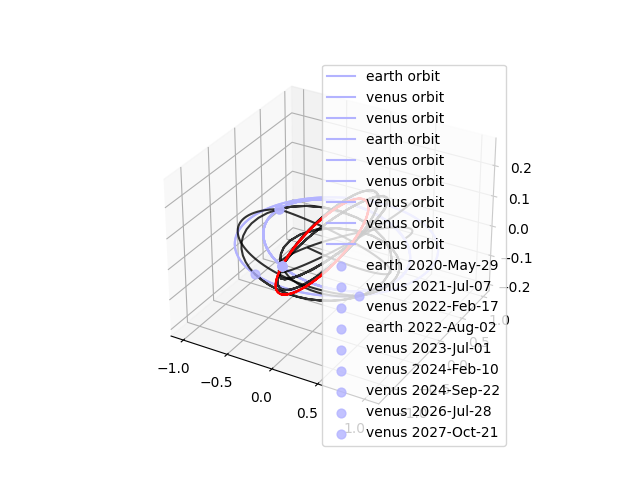

/home/moritz/.local/lib/python3.8/dist-packages/pykep/trajopt/gym/_solar_orbiter.py:659: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection="3d")


<IPython.core.display.Javascript object>


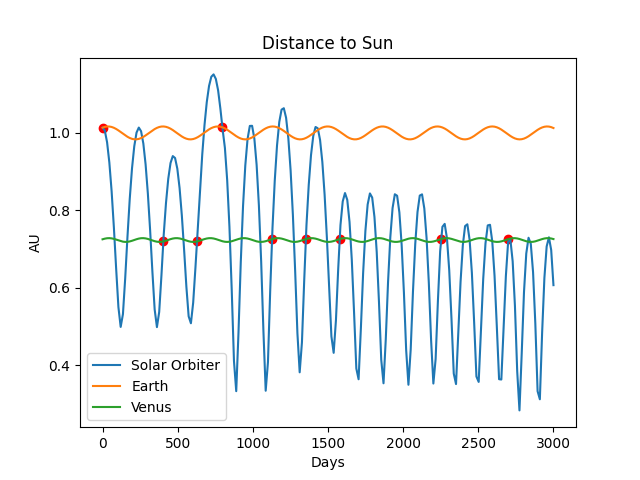

In [5]:
solar_orbiter.plot(x)
solar_orbiter.plot_distance_and_flybys(x)
plt.show()

<IPython.core.display.Javascript object>


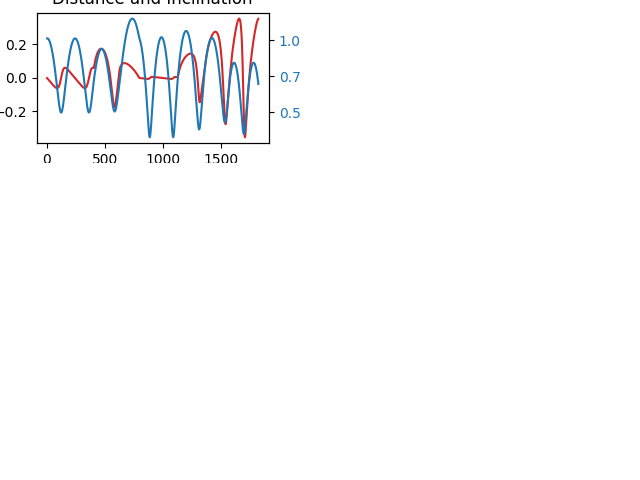

In [6]:
# Plot inclination and distance
timeframe = range(1,5*365)
distances = []
inclinations = []
for i in timeframe:
    epoch = x[0]+i
    pos, _ = solar_orbiter.eph(x, epoch)
    inclination = sign(pos[2])*acos(norm(pos[:2]) / norm(pos))
    distances.append(norm(pos) / AU)
    inclinations.append(inclination)

color = 'tab:red'
fig2, ax2 = plt.subplots()
ax2.plot(list(timeframe), inclinations, color=color)
ax2.set_ylabel("Inclination", color=color)
ax2.set_xlabel("Days")
ax2.set_title("Distance and Inclination")

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('AU', color=color)
ax3.plot(list(timeframe), distances, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig2.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Solar Orbiter modeled as mga_1dsm

In [7]:
# Solution from Dietmar Wolz, at https://gist.github.com/dietmarwo/86f24e1b9a702e18615b767e226e883f
x = [7454.227192641146, 0.4423260291238188, 0.6302883057062232, 5599.894458722009, 0.7401095862496564, 404.2492226073736, 0.15597148623687598, 1.0580076618074068, 0.5101575847266027, 224.70077856657431, -2.4933856179307377, 1.6963855192653385, 0.2901090720064779, 166.75556035570827, 1.6526396514193433, 1.0991472801826805, 0.7121915384668397, 332.20042106080774, -0.23546201156899235, 1.0578347798406122, 0.4655083705172811, 224.70070445614851, 0.036302301169642275, 1.0585127275180912, 0.5295285687741118, 224.70066944051027, 0.9905167586625055, 1.0579496308868774, 0.40373301194586536, 674.102018785453, 0.4999699781508085, 1.0585074637313125, 0.862087191395979, 449.4013947111085, 0.09134030084117842, 1.0611243930405114, 0.506628071700843, 449.40141784746976, 1.042759861414433, 1.5785454129349583]

In [8]:
seq = [earth, venus, venus, earth, venus, venus, venus, venus, venus, venus]
solar_orbiter = solar_orbiter_1dsm#([7000, 8000], seq=seq, max_revs=3)
print (str(solar_orbiter.fitness(x))) 
solar_orbiter.pretty(x)

[1.252801638335015, 0.02030269981672478, -1444.5573693899228, -8.26419834493719e-05, -0.18521217850250649]
Multiple Gravity Assist (MGA) problem: 
Planet sequence:  ['earth', 'venus', 'venus', 'earth', 'venus', 'venus', 'venus', 'venus', 'venus', 'venus']
Departure:  earth
	Epoch:  7454.227192641146  [mjd2000]
	Spacecraft velocity:  [22086.241893256294, -9337.95852311846, -1458.6795402746172] [m/s]
	Launch velocity:  [-5055.32620584562, 1916.5661529338704, -1459.201522321116] [m/s]
	Outgoing Inclination: 3.4816012003567005 [deg]
	Number of Revolutions: 0
	Lambert Index: 0
Fly-by:  venus
	Epoch:  7858.4764152485195  [mjd2000]
	DSM at  7973.10922172823
	DV:  0.0003316915657110589 [m/s]
	Outgoing Inclination: 10.013372922760018 [deg]
	Number of Revolutions: 0
	Lambert Index: 0
Fly-by:  venus
	Epoch:  8083.177193815094  [mjd2000]
	DSM at  8131.554494681809
	DV:  0.005691318305744626 [m/s]
	Outgoing Inclination: 5.07557780996936 [deg]
	Number of Revolutions: 0
	Lambert Index: 0
Fly-by:  ear

<IPython.core.display.Javascript object>


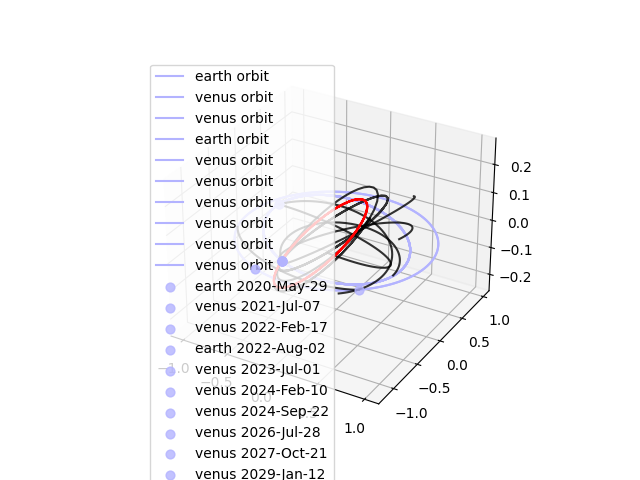

/home/moritz/.local/lib/python3.8/dist-packages/pykep/trajopt/gym/_solar_orbiter.py:1015: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection="3d")


<IPython.core.display.Javascript object>


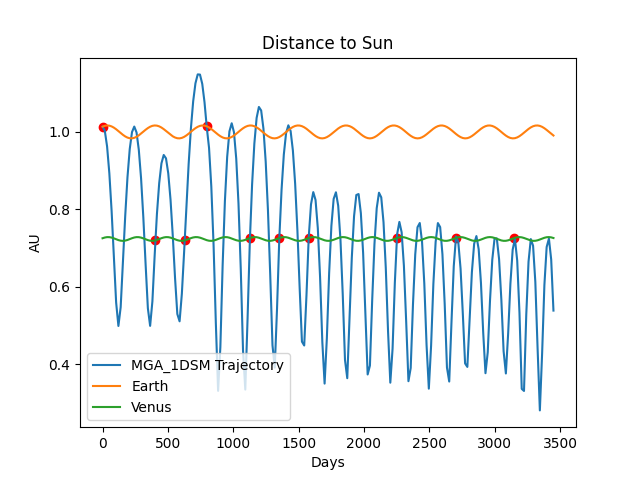

In [9]:
solar_orbiter.plot(x)
solar_orbiter.plot_distance_and_flybys(x)
plt.show()

<IPython.core.display.Javascript object>


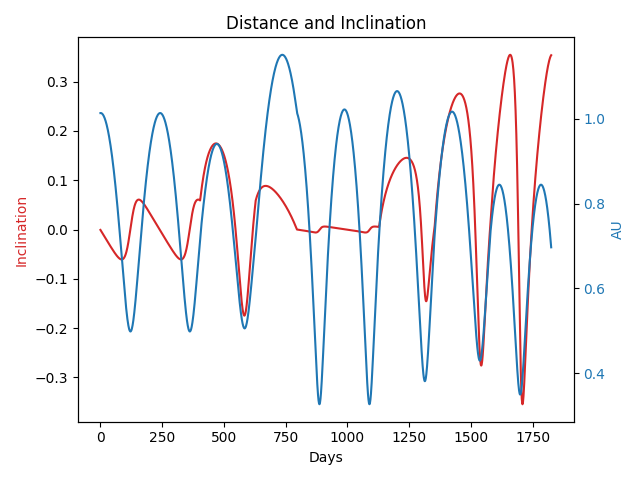

In [10]:
# Plot inclination and distance
distances = []
inclinations = []
eph_function = solar_orbiter.get_eph_function(x)
for i in timeframe:
    epoch = x[0]+i
    pos, _ = eph_function(epoch)
    inclination = sign(pos[2])*acos(norm(pos[:2]) / norm(pos))
    distances.append(norm(pos) / AU)
    inclinations.append(inclination)

color = 'tab:red'
fig2, ax2 = plt.subplots()
ax2.plot(list(timeframe), inclinations, color=color)
ax2.set_ylabel("Inclination", color=color)
ax2.set_xlabel("Days")
ax2.set_title("Distance and Inclination")

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('AU', color=color)
ax3.plot(list(timeframe), distances, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig2.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()